In [1]:
import os
import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

dataset_path = "C:/Users/user/Desktop/[사이버 보안 챌린지 2020] 자동차 해킹공격방어_데이터셋/학습용 데이터셋"
print(os.listdir(dataset_path))

['Cybersecurity_Car_Hacking_D_training-0.csv', 'Cybersecurity_Car_Hacking_D_training-1.csv', 'Cybersecurity_Car_Hacking_D_training-2.csv', 'Cybersecurity_Car_Hacking_S_training-0.csv', 'Cybersecurity_Car_Hacking_S_training-1.csv', 'Cybersecurity_Car_Hacking_S_training-2.csv']


# 6개 파일 전체 Load

In [2]:
all_dfs = []

for file_name in os.listdir(dataset_path):
    if "csv" not in file_name:
        continue
    all_dfs.append(pd.read_csv(os.path.join(dataset_path, file_name)))

all_dfs = pd.concat(all_dfs)

all_dfs.head()

,Timestamp,Arbitration_ID,DLC,Data,Class,SubClass
0,1.597708e+09,260,8,06 25 05 30 FF CF 71 55,Normal,NaN
1,1.597708e+09,329,8,4A C5 7E 8C 31 2D 01 10,Normal,NaN
2,1.597708e+09,38D,8,00 00 49 00 90 7F FE 01,Normal,NaN
3,1.597708e+09,420,8,50 1E 00 C8 FC 4F 6A 00,Normal,NaN
4,1.597708e+09,421,8,FE 07 00 FF E3 7F 00 52,Normal,NaN


# Drive 정상치 데이터 Load

In [2]:
D_normal_dfs=[]
D_normal_dfs.append(pd.read_csv(os.path.join(dataset_path, 'Cybersecurity_Car_Hacking_D_training-0.csv')))
D_normal_dfs = pd.concat(D_normal_dfs)

D_normal_dfs.head()

,Timestamp,Arbitration_ID,DLC,Data,Class
0,1.597708e+09,260,8,06 25 05 30 FF CF 71 55,Normal
1,1.597708e+09,329,8,4A C5 7E 8C 31 2D 01 10,Normal
2,1.597708e+09,38D,8,00 00 49 00 90 7F FE 01,Normal
3,1.597708e+09,420,8,50 1E 00 C8 FC 4F 6A 00,Normal
4,1.597708e+09,421,8,FE 07 00 FF E3 7F 00 52,Normal


# ID : 16진수 -> 2진수 변경 (64bit)

In [ ]:
D_normal_dfs=[]
D_normal_dfs.append(pd.read_csv(os.path.join(dataset_path, 'Cybersecurity_Car_Hacking_D_training-0.csv')))
D_normal_dfs = pd.concat(D_normal_dfs)

can_id = D_normal_dfs["Arbitration_ID"]
label = D_normal_dfs["Class"]
# payload = all_dfs["Data"]

can_id = can_id.apply(lambda x: int(str(x), 16))
#parsed_can_id = can_id.apply(lambda x: format(int(x), 'b'))

binary_can_id=can_id.apply(lambda x: format(int(x), 'b'))

for i in range(len(binary_can_id)):
    if len(binary_can_id[i])!=16:
        binary_can_id[i]="0"*(16-len(binary_can_id[i]))+binary_can_id[i]

sperated_can_id=[]
for i in range(len(binary_can_id)):
    for j in range(len(binary_can_id[0])):
        sperated_can_id.append(binary_can_id[i][j])

sperated_can_id=np.array(sperated_can_id[0:2869504])
matrix=np.reshape(sperated_can_id,(11209,16,16))
matrix=matrix.astype(np.float32)

# DCGAN Model 생성

In [14]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from PIL import Image

In [15]:
img_rows = 16
img_cols = 16
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

In [16]:
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 4 * 4, activation="relu", input_dim=latent_dim))
    model.add(Reshape((4, 4, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    model.summary()
    noise = Input(shape=(latent_dim,))
    img = model(noise)
    return Model(noise, img)

In [17]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)

In [18]:
optimizer = Adam(0.0002, 0.5)

# build discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# build generator
generator = build_generator()
z = Input(shape=(100,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 32)          320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8, 8, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 5, 5, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 64)          0

In [28]:
import random
def train(epochs, batch_size=128, save_interval=50):
    #os.makedirs('images', exist_ok=True)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    # DATA LOAD
    # Rescale -1 to 1
    D_normal_dfs=[]
    D_normal_dfs.append(pd.read_csv(os.path.join(dataset_path, 'Cybersecurity_Car_Hacking_D_training-0.csv')))
    D_normal_dfs = pd.concat(D_normal_dfs)
    
    # ID : 16진수 -> 2진수 변경 (64bit)
    can_id = D_normal_dfs["Arbitration_ID"]
    label = D_normal_dfs["Class"]

    can_id = can_id.apply(lambda x: int(str(x), 16))

    binary_can_id=can_id.apply(lambda x: format(int(x), 'b'))

    for i in range(len(binary_can_id)):
        if len(binary_can_id[i])!=16:
            binary_can_id[i]="0"*(16-len(binary_can_id[i]))+binary_can_id[i]

    sperated_can_id=[]
    for i in range(len(binary_can_id)):
        for j in range(len(binary_can_id[0])):
            sperated_can_id.append(binary_can_id[i][j])

    sperated_can_id=np.array(sperated_can_id[0:2869504])
    matrix=np.reshape(sperated_can_id,(11209,16,16))
    matrix=matrix.astype(np.float32)

    for epoch in range(epochs):
        # Select a random real images
        idx = np.random.randint(0, 11209, 32)
        real_imgs = matrix[idx]
        # Sample noise and generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise)

        # Train the discriminator
        D_loss_real = discriminator.train_on_batch(real_imgs, valid)
        D_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
        D_loss = 0.5 * np.add(D_loss_real, D_loss_fake)

        # Train the generator
        g_loss = combined.train_on_batch(noise, valid)

        # If at save interval
        if epoch % save_interval == 0:
            # Print the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, D_loss[0], 100 * D_loss[1], g_loss))
            # Save generated image samples
            save_imgs(epoch)

In [44]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("C:/Users/user/Desktop/GAN/CAN_matrix/CAN_MATRIX_%d.png" % epoch)
    plt.close()
    return gen_imgs

In [31]:
start = time.time()

train(epochs=10000, batch_size=32, save_interval=1000)

end = time.time()
elapsed_train_time = 'elapsed training time: {} min, {} sec '.format(int((end - start) / 60),
                                                                     int((end - start) % 60))
print(elapsed_train_time)

0 [D loss: 0.000182, acc.: 100.00%] [G loss: 0.635399]
1000 [D loss: 0.000062, acc.: 100.00%] [G loss: 0.120962]
2000 [D loss: 0.000494, acc.: 100.00%] [G loss: 0.138282]
3000 [D loss: 0.000170, acc.: 100.00%] [G loss: 0.018263]
4000 [D loss: 0.000097, acc.: 100.00%] [G loss: 2.605536]
5000 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.971242]
6000 [D loss: 0.000012, acc.: 100.00%] [G loss: 2.561066]
7000 [D loss: 0.000002, acc.: 100.00%] [G loss: 3.066875]
8000 [D loss: 0.000001, acc.: 100.00%] [G loss: 4.035777]
9000 [D loss: 0.000000, acc.: 100.00%] [G loss: 3.605729]
elapsed training time: 7 min, 39 sec 


In [34]:
#os.makedirs('C:/Users/user/Desktop/GAN/saved_model_weights', exist_ok=True)
generator.save_weights('C:/Users/user/Desktop/GAN/CAN_saved_model_weights/generator_weights.h5')
discriminator.save_weights('C:/Users/user/Desktop/GAN/CAN_saved_model_weights/discriminator_weights.h5')
combined.save_weights('C:/Users/user/Desktop/GAN/CAN_saved_model_weights/combined_weights.h5')

In [40]:
import cv2
image_dataset_path="C:/Users/user/Desktop/GAN/CAN_matrix"

created_images=[]
for file_name in os.listdir(image_dataset_path):
    if "000" not in file_name:
        continue
    created_images.append(cv2.imread(os.path.join(image_dataset_path, file_name)))

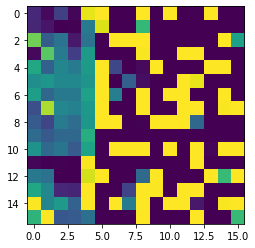

In [47]:
plt.imshow(im[0])

In [96]:
im=save_imgs(10)

In [97]:
img1=im[0]*255
_, thr = cv2.threshold(img1, 200, 255, cv2.THRESH_BINARY)
thr_img=thr/255

In [98]:
thr_img[:,0:5]=0

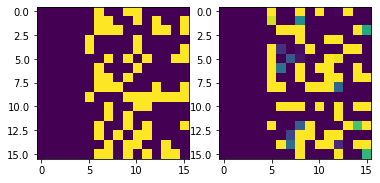

In [99]:
im[0][:,0:5]=0
plt.subplot(1,2,1)
plt.imshow(matrix[0],)
plt.subplot(1,2,2)
plt.imshow(im[0])

In [88]:
thr_img.shape

(16, 16)

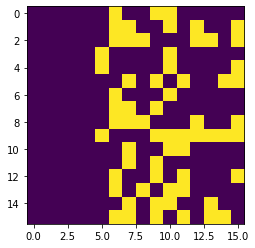

In [89]:
plt.imshow(matrix[0])

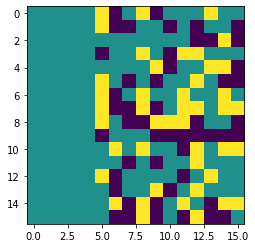

In [90]:
mat=np.array(thr_img-matrix[0]).astype(np.int32)
plt.imshow(mat)

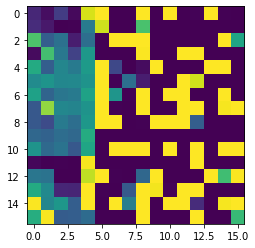

In [91]:
plt.imshow(im[0])

# 실패!